In [1]:
# Libraries to install

# !pip install glob
# !pip install wordcloud
# import nltk
# nltk.download('stopwords')
# nltk.download('words')
# !pip install pyldavis
# !pip install eng_to_ipa
# !pip install spacy
# !pip install gensim

In [2]:
import pandas as pd
import numpy as np
import glob,os,re
import string

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.manifold import TSNE

from collections import Counter
import eng_to_ipa as p

import nltk
from nltk.corpus import stopwords,words
from nltk import word_tokenize

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import TfidfModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


from IPython.display import display

## Data Extraction

In [3]:
def read_data(folder_path):
    '''
    This method reads all the txt files from the folder_path
    and saves the file name and text into a dataframe
    Returns : Dataframe
    '''
    file_list = glob.glob(folder_path + "/*.txt")
    songs= list()

    for file in file_list:
        with open(file,'r') as f:
            file_name = os.path.basename(file).split('.')[0]
            songs.append((file_name,f.read()))


    songs_df= pd.DataFrame(songs,columns=['song_name','lyrics'])
    return songs_df

path = './lyrics/'
songs_df =read_data(path)
songs_df

,song_name,lyrics
0,Anna-go-to-him,"Anna, you come and ask me girl\nTo set you fre..."
1,yesterday,"Yesterday, all my troubles seemed so far away\..."
2,i-need-you,You don't realize how much I need you\nLove yo...
3,the-ballad-of-john-and-yoko,Standing in the dock at Southampton\ntrying to...
4,one-after-909,My baby says she's traveling\non the one after...
...,...,...
274,real-love,"All my little plans and schemes,\nlost like so..."
275,medley-kansas-city-hey-hey-hey-hey,\n
276,the-honeymoon-song,\n
277,misery,The world is treating me bad\nMisery\nI'm the ...


In [4]:
songs_df.shape

(279, 2)

In [5]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   song_name  279 non-null    object
 1   lyrics     279 non-null    object
dtypes: object(2)
memory usage: 4.5+ KB


##### The song names and lyrics are extracted into a dataframe.
##### There are no null values in song_name or lyrics.

## Data Cleaning

Summary of this section :
 -  The extracted data is scanned to find if any file is empty or irrelevant.
 - Checking the number of lines of lyrics to extract small files
 - Checking for identical song_name or lyrics
 -  Deleting songs that are not in english.
 - Checking if there is repetition(sub string) in songs names.


In [6]:
# Checking for empty files

empty_files = songs_df[(songs_df.lyrics =='\n') | (songs_df.lyrics==' ')]
print(empty_files.shape[0])

58


In [7]:
# Removing empty files 
songs_df = songs_df[(songs_df.lyrics !='\n') | (songs_df.lyrics==' ')]
songs_df.shape

(221, 2)

In [8]:
# Creating new column for length of lines in lyrics
songs_df['lenght'] = [len(l.split('\n')) for l in songs_df.lyrics.to_list()]
songs_df

/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_84338/2370633430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df['lenght'] = [len(l.split('\n')) for l in songs_df.lyrics.to_list()]


,song_name,lyrics,lenght
0,Anna-go-to-him,"Anna, you come and ask me girl\nTo set you fre...",38
1,yesterday,"Yesterday, all my troubles seemed so far away\...",17
2,i-need-you,You don't realize how much I need you\nLove yo...,33
3,the-ballad-of-john-and-yoko,Standing in the dock at Southampton\ntrying to...,53
4,one-after-909,My baby says she's traveling\non the one after...,44
...,...,...,...
271,ill-get-you,"Oh yeah, oh yeah,\noh yeah, oh yeah,\nImagine ...",37
272,if-i-needed-someone,If I needed someone to love\nYou're the one th...,24
274,real-love,"All my little plans and schemes,\nlost like so...",41
277,misery,The world is treating me bad\nMisery\nI'm the ...,21


In [9]:
# Cleaning song_name and lyrics to remove punctuation and numbers
def clean_text(text):
    '''
    This method cleans the text by removing punctuations, numbers and double white spaces
    Returns : cleaned text
    '''
    text = text.lower()
    text = re.sub(r"[^\\\w\s]",' ',text)
    text = re.sub(r"[0-9]",'',text)
    text = re.sub(r"  ",' ',text)
    return text.strip()


    

In [10]:
def clean_name_lyrics(df):
    '''
    This methods cleans columns songs_name and lyrics in the dataframe
    Return : Cleaned dataframe
    '''
    df['song_name'] = df.song_name.apply(clean_text)
    df['lyrics'] = df.lyrics.apply(clean_text)
    return df


songs_df = clean_name_lyrics(songs_df)
songs_df

/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_84338/1465755159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['song_name'] = df.song_name.apply(clean_text)
/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_84338/1465755159.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lyrics'] = df.lyrics.apply(clean_text)


,song_name,lyrics,lenght
0,anna go to him,anna you come and ask me girl\nto set you free...,38
1,yesterday,yesterday all my troubles seemed so far away\n...,17
2,i need you,you don t realize how much i need you\nlove yo...,33
3,the ballad of john and yoko,standing in the dock at southampton\ntrying to...,53
4,one after,my baby says she s traveling\non the one after...,44
...,...,...,...
271,ill get you,oh yeah oh yeah \noh yeah oh yeah \nimagine i ...,37
272,if i needed someone,if i needed someone to love\nyou re the one th...,24
274,real love,all my little plans and schemes \nlost like so...,41
277,misery,the world is treating me bad\nmisery\ni m the ...,21


In [11]:
# Checking for songs with less than 10 lines 
songs_df[songs_df.lenght<=10]


,song_name,lyrics,lenght
74,the end,oh yeah all right\nare you gonna be in my drea...,8
166,sun king,ah\nhere comes the sun king\nhere comes the su...,10
226,cayenne,none instrumental song,2
239,a beginning,none instrumental song,2
245,cry for a shadow,none this is an instrumental,2
268,words of love,hold me close and tell me how you feel\ntell m...,10


In [12]:
# Removing songs with not relevant lyrics 
songs_df= songs_df[songs_df.lenght>5]
songs_df

,song_name,lyrics,lenght
0,anna go to him,anna you come and ask me girl\nto set you free...,38
1,yesterday,yesterday all my troubles seemed so far away\n...,17
2,i need you,you don t realize how much i need you\nlove yo...,33
3,the ballad of john and yoko,standing in the dock at southampton\ntrying to...,53
4,one after,my baby says she s traveling\non the one after...,44
...,...,...,...
271,ill get you,oh yeah oh yeah \noh yeah oh yeah \nimagine i ...,37
272,if i needed someone,if i needed someone to love\nyou re the one th...,24
274,real love,all my little plans and schemes \nlost like so...,41
277,misery,the world is treating me bad\nmisery\ni m the ...,21


In [13]:
#Checking for duplicates
songs_df[songs_df.duplicated()]

,song_name,lyrics,lenght


In [14]:
# Checking for duplicates in song name
songs_df[songs_df.song_name.duplicated()]

,song_name,lyrics,lenght
244,revolution,you say you want a revolution\nwell you know\n...,36


In [15]:
# Checking for duplicates in lyrics
songs_df[songs_df.lyrics.duplicated()]

,song_name,lyrics,lenght
155,lucy in the sky with diamonds,picture yourself on a boat on a river\nwith ta...,33
180,a day in the life,i read the news today oh boy\nabout a lucky ma...,36
209,yellow submarine,in the town where i was born\nlived a man who ...,35


#### 3 songs have matching lyrics and 1 has matching song name. 
### Removing songs with matching song name from the dataframe

In [16]:
songs_df.drop([244],inplace=True)
songs_df.shape

/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_84338/3811403027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df.drop([244],inplace=True)


(217, 3)

In [17]:
# Creating new column processed_text by combining song_name and lyrics and removing stopwords

def join_remove_stopwords(name,lyrics):
    '''
    Given the name and lyrics of song, join them, clean text and removes stopwords and return the processed text
    '''
    stop_words = set(stopwords.words('english'))
    
    text = name +' '+lyrics
    
    text = text.strip()
    text = re.sub(r"[0-9]",'',text)
    text = re.sub(r"\n",' ',text)
    text = re.sub(r"  ",' ',text)
    text=re.sub('[%s]' % re.escape(string.punctuation), '', text.lower())
    
    word_tokens = word_tokenize(text)
    filtered_text = [w for w in word_tokens if not w in stop_words] 
    
    return (' '.join(filtered_text))
    

In [18]:
songs_df['processed_text'] = songs_df.apply(lambda x :join_remove_stopwords(x['song_name'],x['lyrics']),axis=1)
songs_df.head()

/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_84338/988263609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df['processed_text'] = songs_df.apply(lambda x :join_remove_stopwords(x['song_name'],x['lyrics']),axis=1)


,song_name,lyrics,lenght,processed_text
0,anna go to him,anna you come and ask me girl\nto set you free...,38,anna go anna come ask girl set free girl say l...
1,yesterday,yesterday all my troubles seemed so far away\n...,17,yesterday yesterday troubles seemed far away l...
2,i need you,you don t realize how much i need you\nlove yo...,33,need realize much need love time never leave p...
3,the ballad of john and yoko,standing in the dock at southampton\ntrying to...,53,ballad john yoko standing dock southampton try...
4,one after,my baby says she s traveling\non the one after...,44,one baby says traveling one said move honey tr...


In [19]:
# Checking for songs with more than 25 non English words
def check_lang(doc):
    '''
    This method check if the doc have more than 25 non English words 
    Returns : Boolean
    '''
    all_word = set(words.words())
    count =0
    
    for d in doc.split():
        
        if d not in all_word:
            count += 1
            
    return True if (count >= 25) else False

In [20]:
songs_df[songs_df.processed_text.apply(check_lang)]

,song_name,lyrics,lenght,processed_text
3,the ballad of john and yoko,standing in the dock at southampton\ntrying to...,53,ballad john yoko standing dock southampton try...
6,three cool cats,three cool cats \nthree cool cats\nare coming ...,54,three cool cats three cool cats three cool cat...
7,it wont be long,it won t be long yeh yeh yeh\nit won t be long...,27,wont long long yeh yeh yeh long yeh yeh yeh lo...
22,komm gib mir deine hand,o komm doch komm zu mir \ndu nimmst mir den ve...,34,komm gib mir deine hand komm doch komm zu mir ...
40,my bonnie,my bonnie lies over the ocean \nmy bonnie lies...,25,bonnie bonnie lies ocean bonnie lies sea bonni...
79,sie liebt dich,sie liebt dich yeah yeah yeah \nsie liebt dich...,42,sie liebt dich sie liebt dich yeah yeah yeah s...
119,being for the benefit of mr kite,for the benefit of mr kite\nthere will be a sh...,22,benefit mr kite benefit mr kite show tonight t...
121,drive my car,asked a girl what she wanted to be\nshe said b...,33,drive car asked girl wanted said baby see wan ...
139,lucy in the sky with diamonds live with yoko,picture yourself on a boat on a river\nwith ta...,33,lucy sky diamonds live yoko picture boat river...
153,searchin,gonna find her gonna find her \n\nwell searchi...,51,searchin gon na find gon na find well searchin...


###### From the above list of songs with more than 25 no english words , komm gib mir deine hand ,sie liebt dich , besame mucho and ob la di ob la da  doesnt sonund english. Checking the lyrics of these songs

In [21]:
display(songs_df.loc[[22,79,160,232]].lyrics.values)

array(['o komm doch komm zu mir \ndu nimmst mir den verstand \no komm doch komm zu mir\nkomm gib mir deine hand \nkomm gib mir deine hand \nkomm gib mir deine hand \no du bist so schön \nschön wie ein diamant \nich will mit dir gehen \nkomm gib mir deine hand \nkomm gib mir deine hand \nkomm gib mir deine hand \nin deinen armen\nbin ich glücklich und froh \ndass war noch nie bei einer andern\neinmal so einmal so einmal so \no komm doch komm zu mir \ndu nimmst mir den verstand \no komm doch komm zu mir \nkomm gib mir deine hand \nkomm gib mir deine hand \nkomm gib mir deine hand \nin deinen armen\nbin ich glücklich und froh \ndass war noch nie bei einer andern\neinmal so einmal so einmal so \no du bist so schön \nschön wie ein diamant \nich will mit dir gehen \nkomm gib mir deine hand \nkomm gib mir deine hand \nkomm gib mir deine hand \nkomm gib mir deine hand',
       'sie liebt dich yeah yeah yeah \nsie liebt dich yeah yeah yeah \nsie liebt dich yeah yeah yeah yeah \ndu glaubst sie l

###### komm gib mir deine hand and sie liebt dich are not english songs. 
### Removing songs not in English from the dataframe

In [22]:
songs_df.drop([22,79],inplace=True)
songs_df.shape

/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_84338/372522758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df.drop([22,79],inplace=True)


(215, 4)

In [23]:
# Finding songs with very similar song names to check if they are repetition
def find_repetition(song_name):
    '''
    This method checks if the song_name is repeated in the dataframe
    Returns : Boolean
    '''
    all_songs = songs_df.song_name.values
    count = 0
    
    for song in all_songs:
        if song_name in song:
            count += 1
            
    return True if (count > 1) else False

In [24]:
rep=songs_df[songs_df.song_name.apply(find_repetition)]

for names in rep.song_name.values:
    display(songs_df[songs_df.song_name.str.contains(names)])
    print('\n')

,song_name,lyrics,lenght,processed_text
39,girl,is there anybody going to listen to my story\n...,29,girl anybody going listen story girl came stay...
91,another girl,for i have got another girl another girl\nyou ...,22,another girl got another girl another girl mak...
104,youre going to lose that girl,you re going to lose that girl\nyou re going t...,30,youre going lose girl going lose girl going lo...
221,thank you girl,ah ah mm you be good to me\nyou made me glad w...,25,thank girl ah ah mm good made glad blue eterna...


,song_name,lyrics,lenght,processed_text
90,sgt peppers lonely hearts club band reprise,we re sgt pepper s lonely heart s club band\nw...,13,sgt peppers lonely hearts club band reprise sg...
93,sgt peppers lonely hearts club band,it was twenty years ago today\nsgt pepper taug...,26,sgt peppers lonely hearts club band twenty yea...


,song_name,lyrics,lenght,processed_text
139,lucy in the sky with diamonds live with yoko,picture yourself on a boat on a river\nwith ta...,33,lucy sky diamonds live yoko picture boat river...
155,lucy in the sky with diamonds,picture yourself on a boat on a river\nwith ta...,33,lucy sky diamonds picture boat river tangerine...


,song_name,lyrics,lenght,processed_text
141,a day in the life live in amsterdam,i read the news today oh boy\nabout a lucky ma...,36,day life live amsterdam read news today oh boy...
180,a day in the life,i read the news today oh boy\nabout a lucky ma...,36,day life read news today oh boy lucky man made...


,song_name,lyrics,lenght,processed_text
126,everybodys got something to hide except me and...,come on come on\ncome on come on\ncome on is s...,41,everybodys got something hide except monkey co...
189,something,something in the way she moves\nattracts me li...,20,something something way moves attracts like lo...


,song_name,lyrics,lenght,processed_text
101,yellow submarine live version,in the town where i was born\nlived a man who ...,35,yellow submarine live version town born lived ...
209,yellow submarine,in the town where i was born\nlived a man who ...,35,yellow submarine town born lived man sailed se...


,song_name,lyrics,lenght,processed_text
223,help,help i need somebody\n help not just anybody\n...,34,help help need somebody help anybody help know...
254,with a little help from my friends,what would you think if i sang out of tune\nwo...,35,little help friends would think sang tune woul...


#### Songs sgt peppers lonely hearts club band, lucy in the sky with diamonds, a day in the life and  yellow submarine have 2 files each.
#### Songs lucy in the sky with diamonds, a day in the life and  yellow submarine have same lyrics.

### Removing songs with matching lyrics  and repetitive files from the dataframe

In [25]:
songs_df.drop([90,139,141,101],inplace=True)
songs_df.reset_index(inplace=True,drop=True)
songs_df

/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_84338/20499457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df.drop([90,139,141,101],inplace=True)


,song_name,lyrics,lenght,processed_text
0,anna go to him,anna you come and ask me girl\nto set you free...,38,anna go anna come ask girl set free girl say l...
1,yesterday,yesterday all my troubles seemed so far away\n...,17,yesterday yesterday troubles seemed far away l...
2,i need you,you don t realize how much i need you\nlove yo...,33,need realize much need love time never leave p...
3,the ballad of john and yoko,standing in the dock at southampton\ntrying to...,53,ballad john yoko standing dock southampton try...
4,one after,my baby says she s traveling\non the one after...,44,one baby says traveling one said move honey tr...
...,...,...,...,...
206,ill get you,oh yeah oh yeah \noh yeah oh yeah \nimagine i ...,37,ill get oh yeah oh yeah oh yeah oh yeah imagin...
207,if i needed someone,if i needed someone to love\nyou re the one th...,24,needed someone needed someone love one thinkin...
208,real love,all my little plans and schemes \nlost like so...,41,real love little plans schemes lost like forgo...
209,misery,the world is treating me bad\nmisery\ni m the ...,21,misery world treating bad misery kind guy neve...


In [26]:
print('Total number of songs after cleaning : ',songs_df.shape[0])

Total number of songs after cleaning :  211


## Data Analysis

Summary of this section

 - Checking thr shape, dtypes and null values
 - Checking the distribution of lenght of songs
 - Checking haow many songs have song name in lyrics
 - Checking how many songs have rhyming lines in lyrics
 - Checking the most common words in all songs
 

In [27]:
songs_df.shape

(211, 4)

In [28]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   song_name       211 non-null    object
 1   lyrics          211 non-null    object
 2   lenght          211 non-null    int64 
 3   processed_text  211 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.7+ KB


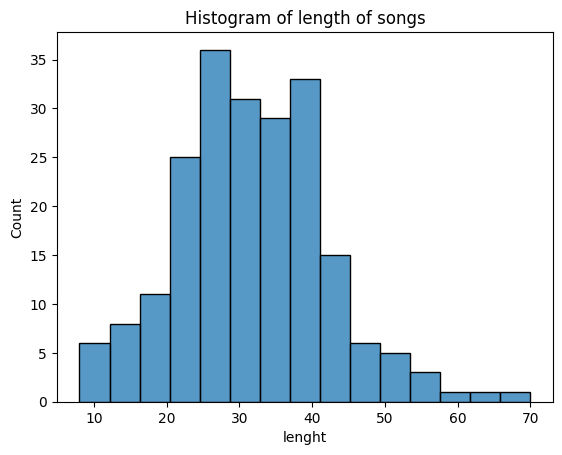

In [29]:
#Checking the distribution of lenght of song

sns.histplot(data=songs_df,x='lenght')
plt.title('Histogram of length of songs')
plt.show()

##### Most songs have 20-40 lines in their lyrics.Very few songs have lenght more than 60 lines

### Checking how many songs have song name in lyrics

Methodology 
 - Getting the cleaned song name and lyrics into the check_name_in_lyrics method
 - Removing all '\n' newline character in lyrics
 - Returning true if the song name is present in lyrics
 - Calculating the sum of songs with song name by taking count of rows with value "True" for song_in_lyrics

In [30]:


def check_name_in_lyrics(name,lyrics):
    '''
    This methods checks if the songs feature the song name in the song lyrics
    '''
    lyrics_clean = lyrics.replace('\n',' ')
    return True if name in lyrics_clean else False

songs_df['name_in_song'] = songs_df.apply(lambda x :check_name_in_lyrics(x['song_name'],x['lyrics']),axis=1)


/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_84338/4092198386.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df['name_in_song'] = songs_df.apply(lambda x :check_name_in_lyrics(x['song_name'],x['lyrics']),axis=1)


In [31]:
print('Number of Songs with name in lyrics : ',songs_df[songs_df.name_in_song==True].shape[0])

Number of Songs with name in lyrics :  153


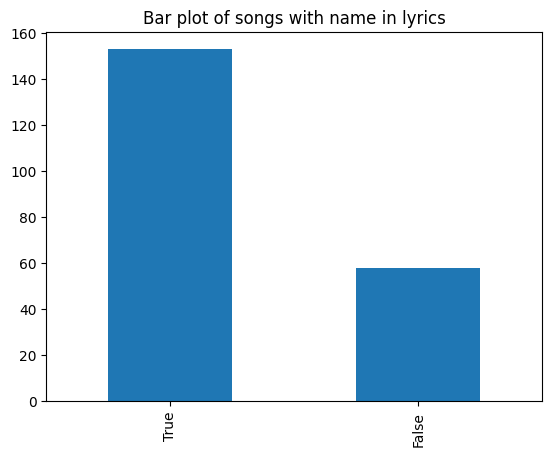

In [32]:
songs_df.name_in_song.value_counts().plot(kind='bar')
# sns.barplot(data=songs_df,x='name_in_song')
plt.title('Bar plot of songs with name in lyrics')
plt.show()

### How many of the songs feature at least one pair of lines that rhyme?

Methodology 

 - Getting the lyrics of the songs as a parameter in check_rhyme method
 - Splitting the songs into each lines
 - Removing duplicate lines in lyrics
 - Creating the phonetic transcript of each line in lyrics using eng_to_ipa library
 - Removing all consonants (non-vowel) characters from phonetic transcript of each line
 - Storing only the vowel sounds of last 3 words in each line
 - Comparing the sounds of last 3 words to determine if there is repetition
 - Returning True if there is repetition and False if not
 - Calculating the sum of rows with 'True' as rhyme value to get number of songs that rhyme

In [33]:
def check_rhyme(lyrics):
    '''
    This methods checks if the songs has rhyming lines in its lyrics
    Method converts each line in lyrics to phonetic transcript, filter out the vowel sounds from them
    and matches if the vowel sounds of last 3 words in each line are matching with any other line
    '''
    lyrics = lyrics.strip().split('\n')
    
    not_vowels = r"[^iuəɪæɛoʊðθɔaʊa]"
    ph_last_words = []
    
    #Creating set of lyrics to remove line repetition
    for l in set(lyrics):
        
        # Converting the lyrics to phonetics transcript
        ph_transcript = p.ipa_list(l)
        vowel_sounds = []
        
        for val in ph_transcript:
            # removing all characters other than vowel sounds
            val[0] = re.sub(not_vowels,'',val[0])
            vowel_sounds.append(val[0])
            
       #Taking only the last 3 words into account
        vowel_sounds = ' '.join(vowel_sounds[-3:])
        ph_last_words.append(vowel_sounds)
        
    # Returning True if repetition in vowel sounds
    return True if (max(Counter(ph_last_words).values())>1) else False
       

In [34]:
songs_df['rhyme'] = songs_df.lyrics.apply(check_rhyme)


/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_84338/2317735148.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df['rhyme'] = songs_df.lyrics.apply(check_rhyme)


In [35]:
print('Number of songs with rhyming lyrics : ',songs_df[songs_df.rhyme==True].shape[0])

Number of songs with rhyming lyrics :  173


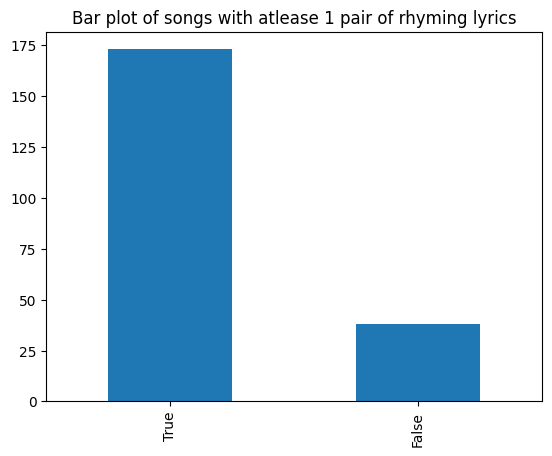

In [36]:
songs_df.rhyme.value_counts().plot(kind='bar')
plt.title('Bar plot of songs with atlease 1 pair of rhyming lyrics')
plt.show()

### Wordcloud of most common words in Beatles songs

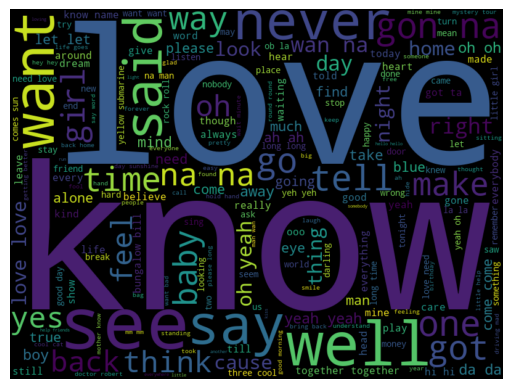

In [37]:
text = ' '.join(songs_df.processed_text.tolist())
wordcloud = WordCloud(collocations=True,background_color='black',width=800, height=600).generate(text)

plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

#### From the above wordcloud , it can be seen that 'love' is one of the most used words in the songs. Few other frequent words are know, well, see, day ,night ,go and want.

## Topic clustering

Summary of the section 

 - Lemmatization
 - Tokenization
 - Creating bi grams and tri-grams
 - Vectorization using TF-IDF vectorizer and removing columns with value 0
 - Implementing LDA model
 - Hyper- parameter tuning
 - Model Analysis and Visualization 
 - Identifying topics clusters
 

In [38]:
def lemmatization(docs, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    '''
    This method create the lemma of words whos pos_tags are in allowed_postages
    Returns : Lematized document containing words which are (nown/adj/verb/adv)
    '''
    nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])
    doc_out = []
    
    for doc in docs:
        doc = nlp(doc)
        new_doc = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_doc.append(token.lemma_)
        final = " ".join(new_doc)
        doc_out.append(final)
    return (doc_out)


lemmatized_doc = lemmatization(songs_df.processed_text.values)



In [39]:
def gen_words(docs):
    '''
    This method tokenizes the document and cleans it
    Return: tokenised document
    '''
    final = []
    for doc in docs:
        new = gensim.utils.simple_preprocess(doc)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_doc)

In [40]:
#BIGRAMS AND TRIGRAMS
def bigram_trigram(data_words):
    '''
    This method creates bi-grams and tri-grams of the data_words
    '''
    bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=50)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=50)

    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)

    data_bigrams= [bigram[doc] for doc in data_words]
    data_bigrams_trigrams = [trigram[bigram[doc]] for doc in data_bigrams]

    return data_bigrams_trigrams

data_bigrams_trigrams = bigram_trigram(data_words)

In [41]:
def tf_idf(data_bigrams_trigrams):
    '''
    This method created tfidf vector of the data provided and removes words of tfidf value 0
    Returns: 
        id2word : Dictionary object
        corpus : BOW format of document
        
    '''
    id2word = corpora.Dictionary(data_bigrams_trigrams)

    texts = data_bigrams_trigrams
    corpus = [id2word.doc2bow(text) for text in texts]

    tfidf = TfidfModel(corpus, id2word=id2word)

    low_value = 0.03
    words  = []
    words_missing_in_tfidf = []
    
    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = [] 
        tfidf_ids = [id for id, value in tfidf[bow]]
        bow_ids = [id for id, value in bow]
        
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] 

        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
        corpus[i] = new_bow
        
    return corpus,id2word


corpus,id2word = tf_idf(data_bigrams_trigrams)

In [42]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           passes=10,
                                           alpha="auto",
                                           iterations=50
                                           )


In [43]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.054*"get" + 0.046*"say" + 0.035*"want" + 0.026*"hold" + 0.024*"go" + 0.017*"call" + 0.015*"help" + 0.014*"way" + 0.013*"fall" + 0.012*"hand"'), (1, '0.043*"know" + 0.031*"name" + 0.024*"look" + 0.023*"back" + 0.016*"come" + 0.015*"tell" + 0.013*"sweet" + 0.013*"try" + 0.012*"away" + 0.012*"sing"'), (2, '0.021*"see" + 0.019*"leave" + 0.018*"still" + 0.013*"sleep" + 0.013*"go" + 0.012*"long" + 0.011*"weep" + 0.011*"never" + 0.011*"round_round" + 0.010*"home"'), (3, '0.072*"go" + 0.026*"day" + 0.025*"way" + 0.025*"good" + 0.025*"take" + 0.024*"life" + 0.021*"find" + 0.021*"home" + 0.021*"sunshine" + 0.019*"birthday"'), (4, '0.060*"love" + 0.056*"know" + 0.033*"come" + 0.032*"say" + 0.024*"girl" + 0.017*"make" + 0.014*"want" + 0.014*"tell" + 0.013*"day" + 0.011*"never"'), (5, '0.060*"get" + 0.042*"good" + 0.028*"morning" + 0.028*"come" + 0.025*"feel" + 0.023*"together" + 0.016*"say" + 0.015*"thank" + 0.013*"guilty" + 0.012*"yellow_submarine_yellow_submarine"'), (6, '0.070*"get" + 0

In [44]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_bigrams_trigrams, dictionary=id2word, coherence='c_v')
with np.errstate(invalid='ignore'):
    coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3812847363422339


In [45]:
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/Users/gayathri/miniforge3/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.028399  0.069390       1        1  31.539438
7     -0.106201  0.033781       2        1  12.808685
8     -0.055740  0.091429       3        1  10.786701
0     -0.082620  0.029567       4        1   9.532938
6     -0.091754 -0.007357       5        1   8.559680
1      0.065624  0.075718       6        1   7.343650
3      0.001929 -0.198046       7        1   6.359800
2      0.037602 -0.060551       8        1   5.173925
9      0.228740  0.056375       9        1   4.597791
5      0.030818 -0.090307      10        1   3.297391, topic_info=       Term        Freq       Total Category  logprob  loglift
80      get  299.000000  299.000000  Default  30.0000  30.0000
10     know  319.000000  319.000000  Default  29.0000  29.0000
8        go  257.000000  257.000000  Default  28.0000  28.0000
12      let  104.000000  104.000000  Default  27.0000  27.0000
14     love  436.000000  436.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
33     look    2.670310   85.152577  Topic10  -5.0953  -0.0502
23    thing    2.348575   69.261519  Topic10  -5.2237   0.0280
140    hear    2.252014   47.441932  Topic10  -5.2657   0.3644
58   really    2.248685   42.510340  Topic10  -5.2672   0.4726
127   right    2.245764   61.143876  Topic10  -5.2685   0.1079

[634 rows x 6 columns], token_table=      Topic      Freq                               Term
term                                                    
474       1  0.205262                                act
474       2  0.102631                                act
474       5  0.513156                                act
474       9  0.102631                                act
639       3  0.628899                              admit
...     ...       ...                                ...
1379     10  0.842531  yellow_submarine_yellow_submarine
45        1  0.084154                          yesterday
45        2  0.757389                          yesterday
45        4  0.084154                          yesterday
1003      3  0.851793                                yet

[1292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 9, 1, 7, 2, 4, 3, 10, 6])

In [46]:
# Hyper-parameter tuning - tuning number of clusters

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    '''
    This method compared the coherence scores of multiple lda models 
    Returns:
        model_list : list of models
        coherence values : coherence scores of each model
    '''
    coherence_values_cv = []
    coherence_values_umass = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics,
                                                id2word=id2word,random_state=100,passes=20,update_every=1)
        model_list.append(model)
        coherencemodel_cv = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherencemodel_umass = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values_cv.append(coherencemodel_cv.get_coherence())
        coherence_values_umass.append(coherencemodel_umass.get_coherence())
    return model_list,coherence_values_cv,coherence_values_umass

In [47]:
model_list, coherence_values_cv,coherence_values_umass = compute_coherence_values(dictionary=id2word, corpus=corpus,
                                                        texts=data_bigrams_trigrams, start=2, limit=20, step=1)

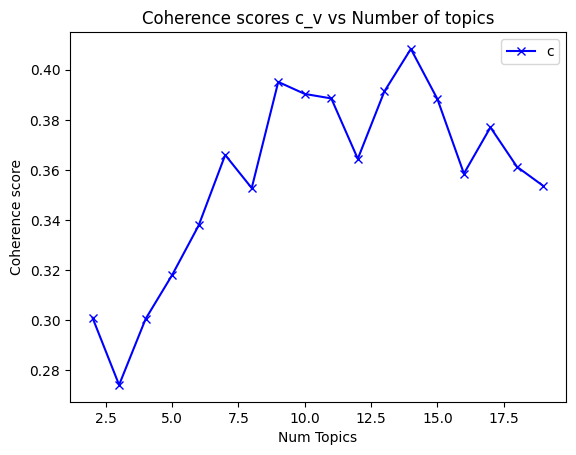

In [48]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values_cv,'bx-')
plt.xlabel("Num Topics")
plt.title('Coherence scores c_v vs Number of topics')
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

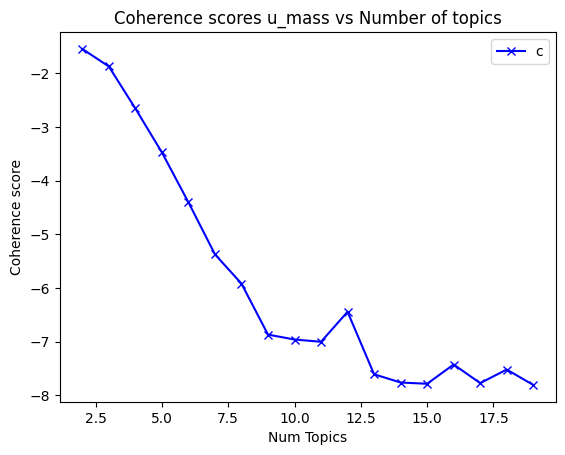

In [49]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values_umass,'bx-')
plt.xlabel("Num Topics")
plt.title('Coherence scores u_mass vs Number of topics')
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [50]:
for m, cv in zip(x, coherence_values_cv):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3009
Num Topics = 3  has Coherence Value of 0.2741
Num Topics = 4  has Coherence Value of 0.3005
Num Topics = 5  has Coherence Value of 0.318
Num Topics = 6  has Coherence Value of 0.3378
Num Topics = 7  has Coherence Value of 0.366
Num Topics = 8  has Coherence Value of 0.3527
Num Topics = 9  has Coherence Value of 0.3951
Num Topics = 10  has Coherence Value of 0.3903
Num Topics = 11  has Coherence Value of 0.3885
Num Topics = 12  has Coherence Value of 0.3644
Num Topics = 13  has Coherence Value of 0.3913
Num Topics = 14  has Coherence Value of 0.4083
Num Topics = 15  has Coherence Value of 0.3883
Num Topics = 16  has Coherence Value of 0.3585
Num Topics = 17  has Coherence Value of 0.377
Num Topics = 18  has Coherence Value of 0.3612
Num Topics = 19  has Coherence Value of 0.3535


Since model with 8 topics have good coherence value , selecting that model

In [51]:
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.048*"let" + 0.043*"get" + 0.035*"say" + 0.028*"hold" + 0.024*"want" + 0.022*"go" + 0.016*"love" + 0.012*"call" + 0.011*"help" + 0.011*"see"'), (1, '0.042*"know" + 0.030*"back" + 0.027*"name" + 0.024*"away" + 0.017*"look" + 0.015*"sweet" + 0.014*"girl" + 0.014*"come" + 0.013*"honey" + 0.013*"try"'), (2, '0.035*"cry" + 0.016*"see" + 0.015*"baby" + 0.015*"leave" + 0.013*"well" + 0.011*"go" + 0.011*"know" + 0.010*"never" + 0.009*"child" + 0.009*"head"'), (3, '0.067*"go" + 0.036*"good" + 0.023*"day" + 0.022*"night" + 0.020*"way" + 0.020*"home" + 0.020*"life" + 0.020*"take" + 0.018*"find" + 0.017*"dream"'), (4, '0.073*"love" + 0.055*"know" + 0.029*"say" + 0.028*"come" + 0.023*"girl" + 0.022*"want" + 0.020*"make" + 0.013*"day" + 0.013*"tell" + 0.011*"baby"'), (5, '0.089*"get" + 0.064*"well" + 0.039*"little" + 0.030*"want" + 0.024*"come" + 0.019*"time" + 0.019*"morning" + 0.016*"together" + 0.016*"help_friend" + 0.016*"feel"'), (6, '0.052*"get" + 0.046*"long" + 0.033*"back" + 0.020*"go

In [52]:
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(optimal_model, corpus, id2word)
LDAvis_prepared

/Users/gayathri/miniforge3/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.036960 -0.073457       1        1  35.591856
7      0.046018 -0.112255       2        1  13.268868
0     -0.080293 -0.057837       3        1  11.568563
6     -0.080806 -0.037860       4        1  11.234848
3      0.110887  0.190715       5        1   8.507180
1      0.125259 -0.028213       6        1   7.822319
2      0.033696  0.023780       7        1   6.063758
5     -0.191720  0.095126       8        1   5.942608, topic_info=     Term        Freq       Total Category  logprob  loglift
80    get  298.000000  298.000000  Default  30.0000  30.0000
10   know  318.000000  318.000000  Default  29.0000  29.0000
14   love  437.000000  437.000000  Default  28.0000  28.0000
132  well  124.000000  124.000000  Default  27.0000  27.0000
8      go  257.000000  257.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
31   hide    5.169670   27.481817   Topic8  -5.0237   1.1523
17    say    8.050002  237.660360   Topic8  -4.5809  -0.5621
140  hear    5.162770   47.544127   Topic8  -5.0251   0.6028
454   end    4.422592   22.572893   Topic8  -5.1798   1.1930
235  mind    4.619842   60.761567   Topic8  -5.1362   0.2464

[504 rows x 6 columns], token_table=      Topic      Freq                               Term
term                                                    
639       4  0.132804                              admit
639       8  0.796824                              admit
1184      5  0.774728                              adore
591       7  0.805202                          affection
1369      5  0.395596                              ahead
...     ...       ...                                ...
1378      8  0.801455              yellow_submarine_live
1379      8  0.903563  yellow_submarine_yellow_submarine
45        1  0.086160                          yesterday
45        2  0.775441                          yesterday
45        3  0.086160                          yesterday

[973 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 1, 7, 4, 2, 3, 6])

From the above visualizations, it is clear that the overlapp between dominant words is very high. So selecting number of topics as 4 after trying different number of topics for minimum overlap

In [53]:
# Checking lda model with number of topics as 6
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.045*"get" + 0.031*"let" + 0.026*"go" + 0.024*"say" + 0.015*"want" + 0.014*"hold" + 0.012*"see" + 0.011*"back" + 0.011*"little" + 0.009*"come"'), (1, '0.033*"baby" + 0.013*"tell" + 0.013*"sweet" + 0.012*"go" + 0.012*"back" + 0.011*"take" + 0.011*"look" + 0.011*"come" + 0.010*"away" + 0.010*"tonight"'), (2, '0.052*"long" + 0.036*"see" + 0.032*"cry" + 0.020*"time" + 0.016*"go" + 0.014*"know" + 0.012*"still" + 0.012*"well" + 0.011*"mother" + 0.011*"old"'), (3, '0.068*"go" + 0.041*"good" + 0.025*"take" + 0.019*"day" + 0.017*"way" + 0.016*"home" + 0.014*"life" + 0.014*"find" + 0.014*"sunshine" + 0.014*"dream"'), (4, '0.074*"love" + 0.055*"know" + 0.028*"say" + 0.025*"come" + 0.023*"want" + 0.021*"girl" + 0.017*"make" + 0.013*"tell" + 0.013*"day" + 0.012*"need"'), (5, '0.097*"get" + 0.046*"back" + 0.028*"well" + 0.025*"time" + 0.018*"come" + 0.016*"real" + 0.014*"feel" + 0.014*"little" + 0.010*"love" + 0.010*"thing"')]


In [54]:
LDAvis_prepared = gensimvis.prepare(optimal_model, corpus, id2word)
LDAvis_prepared

/Users/gayathri/miniforge3/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.043535 -0.047684       1        1  41.751345
0     -0.069834  0.068068       2        1  17.932451
1      0.072370 -0.145099       3        1  10.711986
2      0.065895 -0.018271       4        1  10.123355
3      0.138094  0.125173       5        1   9.846670
5     -0.162988  0.017813       6        1   9.634194, topic_info=     Term        Freq       Total Category  logprob  loglift
80    get  299.000000  299.000000  Default  30.0000  30.0000
10   know  324.000000  324.000000  Default  29.0000  29.0000
8      go  253.000000  253.000000  Default  28.0000  28.0000
14   love  440.000000  440.000000  Default  27.0000  27.0000
32   long   99.000000   99.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
140  hear    8.541024   47.612839   Topic6  -5.0048   0.6216
14   love   12.870917  440.409427   Topic6  -4.5947  -1.1929
8      go   10.042130  253.540357   Topic6  -4.8429  -0.8889
82   good    8.213553   92.630945   Topic6  -5.0439  -0.0830
17    say    7.308854  238.385642   Topic6  -5.1606  -1.1450

[402 rows x 6 columns], token_table=      Topic      Freq                               Term
term                                                    
1000      4  0.779952                               ache
639       2  0.129985                              admit
639       6  0.779910                              admit
591       4  0.779937                          affection
765       1  0.208852                                ago
...     ...       ...                                ...
1377      6  0.879595                   yellow_submarine
1378      6  0.783327              yellow_submarine_live
1379      6  0.882070  yellow_submarine_yellow_submarine
45        1  0.086033                          yesterday
45        2  0.860326                          yesterday

[734 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 3, 4, 6])

In [55]:
all_topics = optimal_model.get_document_topics(corpus)
num_docs = len(all_topics)

all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()

major_topic = [np.argmax(arr) for arr in all_topics_numpy]
songs_df['Topic'] = major_topic

/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_84338/1188321788.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df['Topic'] = major_topic


In [56]:
print(songs_df.Topic.value_counts())

4    93
0    37
1    25
2    21
3    19
5    16
Name: Topic, dtype: int64


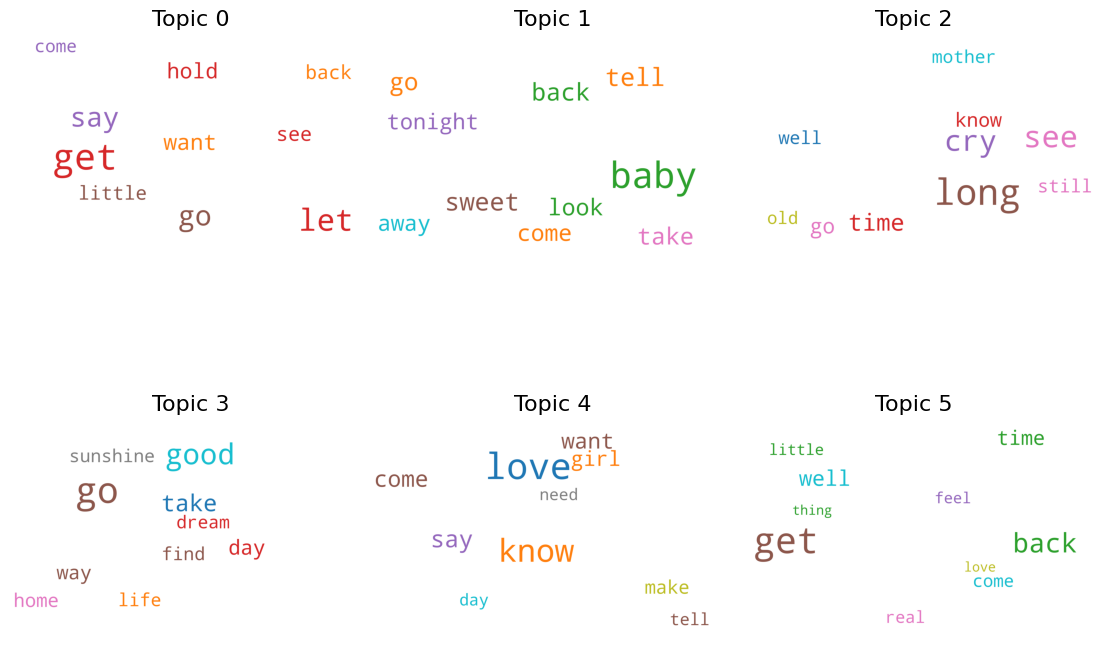

In [57]:
## Word cloud of top N words in each topic 
cloud = WordCloud(background_color='white',
                  width=3000,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(14,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(topics):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    


plt.subplots_adjust(wspace=0, hspace=0)

From above word clouds of top 10 words in each topics, the theme of each cluster can be deduced

In [58]:
# Mapping each cluster value to a theme
topics = {0:'Desire',
         1:'Prosperity',
         2:'Nostalgia',
         3:'Happiness',
         4:'Love',
         5:'Aspiration'}

In [59]:
songs_df['Topic_title'] = songs_df["Topic"].map(topics)
songs_df.head()

/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_84338/3861854917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_df['Topic_title'] = songs_df["Topic"].map(topics)


,song_name,lyrics,lenght,processed_text,name_in_song,rhyme,Topic,Topic_title
0,anna go to him,anna you come and ask me girl\nto set you free...,38,anna go anna come ask girl set free girl say l...,False,True,4,Love
1,yesterday,yesterday all my troubles seemed so far away\n...,17,yesterday yesterday troubles seemed far away l...,True,False,0,Desire
2,i need you,you don t realize how much i need you\nlove yo...,33,need realize much need love time never leave p...,True,True,4,Love
3,the ballad of john and yoko,standing in the dock at southampton\ntrying to...,53,ballad john yoko standing dock southampton try...,False,True,0,Desire
4,one after,my baby says she s traveling\non the one after...,44,one baby says traveling one said move honey tr...,True,True,4,Love


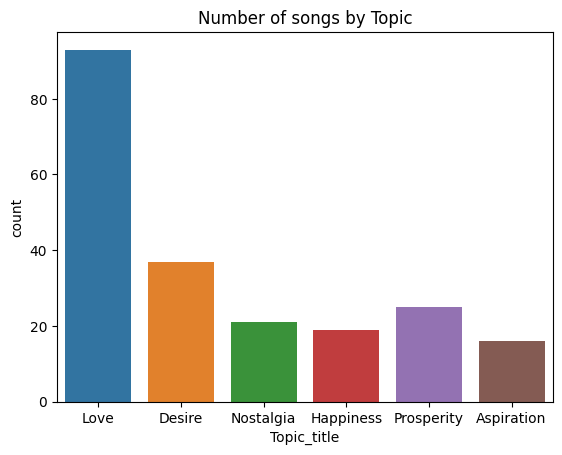

In [60]:
sns.countplot(x="Topic_title", data=songs_df)
plt.title('Number of songs by Topic')
plt.show()

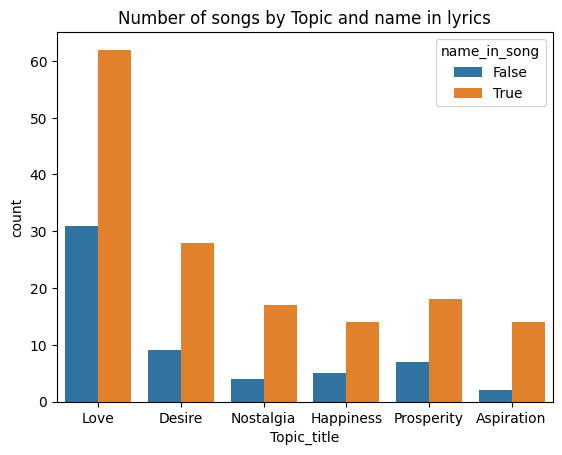

In [61]:
sns.countplot(x="Topic_title", data=songs_df,hue='name_in_song')
plt.title('Number of songs by Topic and name in lyrics')
plt.show()

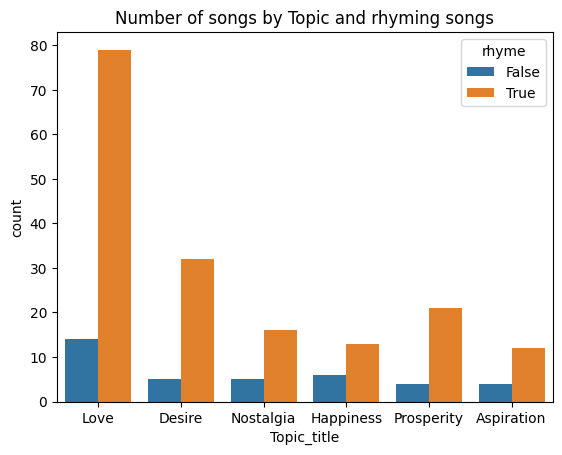

In [62]:
sns.countplot(x="Topic_title", data=songs_df,hue='rhyme')
plt.title('Number of songs by Topic and rhyming songs')
plt.show()

## Topic clustering new songs

In [63]:
def cluster_songs(folder_path):
    
    test = read_data(folder_path)
    test = clean_name_lyrics(test)
    test['processed_text'] = test.apply(lambda x :join_remove_stopwords(x['song_name'],x['lyrics']),axis=1)
    data_bigram_trigram =bigram_trigram(gen_words(lemmatization(test.processed_text.values)))
    
    corpus,id2word = tf_idf(data_bigram_trigram)
    for i in range(len(test)):
        wordcloud = WordCloud(collocations=True,background_color='black',width=800, height=600).generate(test.processed_text[i])

        plt.imshow(wordcloud, interpolation='bilInear')
        plt.title(" Song : {}".format(test.song_name[i]) )
        plt.axis('off')
        plt.show()
    all_topics = optimal_model.get_document_topics(corpus)
    
    num_docs = len(all_topics)

    all_topics_csr= gensim.matutils.corpus2csc(all_topics)
    print("Topic distribution for each song :\n " ,(all_topics_csr.T.toarray()))
    all_topics_numpy= all_topics_csr.T.toarray()

    major_topic= [np.argmax(arr) for arr in all_topics_numpy]
    test['Topic']= major_topic
    test['Topic_title'] = test["Topic"].map(topics)
    return test
    
    

    

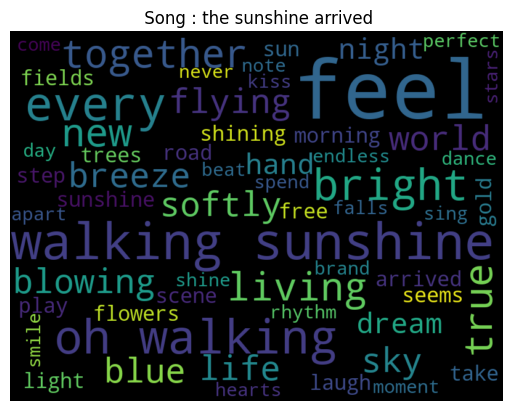

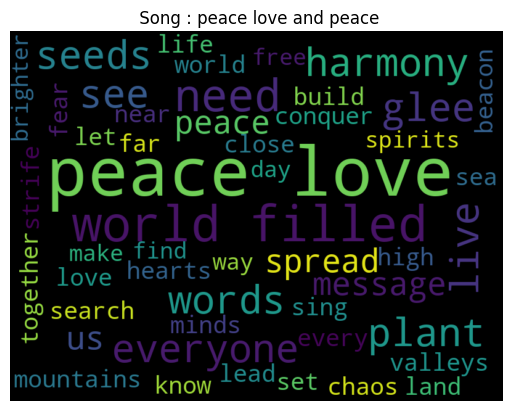

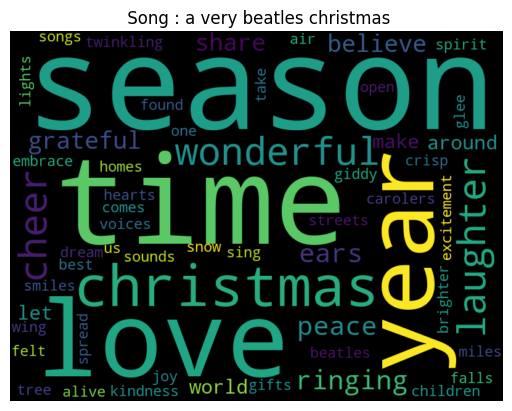

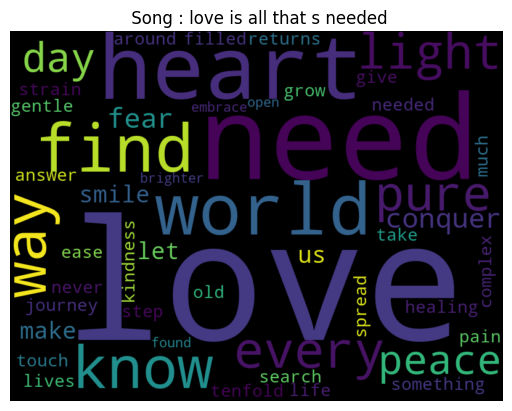

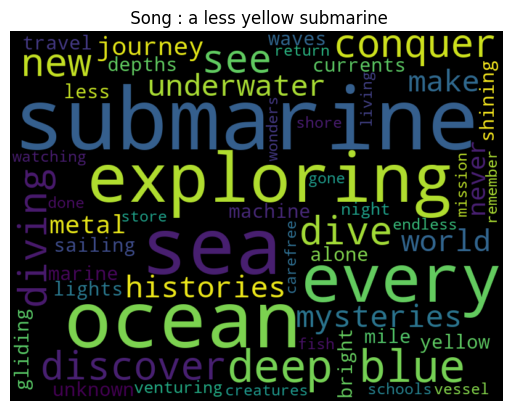

Topic distribution for each song :
  [[0.17106721 0.         0.         0.02055608 0.8031196 ]
 [0.73428065 0.         0.         0.01847385 0.24145938]
 [0.5001986  0.         0.         0.         0.49172726]
 [0.50602454 0.         0.         0.         0.48697984]
 [0.78440833 0.04193045 0.         0.         0.16811214]]


,song_name,lyrics,processed_text,Topic,Topic_title
0,the sunshine arrived,in the morning light i feel so free\nwith the ...,sunshine arrived morning light feel free sun s...,4,Love
1,peace love and peace,in a world that s filled with chaos and strife...,peace love peace world filled chaos strife sea...,0,Desire
2,a very beatles christmas,it s that time of year when the world comes al...,beatles christmas time year world comes alive ...,0,Desire
3,love is all that s needed,in a world that s so complex and filled with p...,love needed world complex filled pain search s...,0,Desire
4,a less yellow submarine,sailing under the sea in a metal machine\nexpl...,less yellow submarine sailing sea metal machin...,0,Desire


In [64]:
folder_path= './new_lyrics/'
test_df =cluster_songs(folder_path)
test_df

4 out of 5 new songs are clustered into "Desire" Topic category. 
 - From the word cloud of these 4 songs, it can be noticed that the top words of these songs have words from both Topics 'Love' and 'Desire'
 - From the top distribution of topics for each documents, it can be seen that for Songs 'a very beatles christmas' and 'love is all that s needed' the distribution of topics Desire and Love are 0.5 and 0.49 respectively. 
 - The topic with highest value - Desire was selected.
 - The other 2 songs 'peace love and peace' and 'a less yellow submarine', 'Desire' topic  has a clear highest topic distribution.

1 song is classified into topic 'Love'
 - Song 'the sunshine arrived' has a lot of common words as in topic Love top words.
 - Topic distribution of this song for Love category is 0.8 which is very high